In [2]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [3]:
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import msgpack
import warnings
from dataclasses import asdict, is_dataclass, dataclass
import os
import msgpack
import json
import pickle
from pandas.api.types import is_datetime64_any_dtype
import scipy
import numpy as np
import polars as pl
from scipy.stats import linregress
from typing import Dict, List

from src.common.AssetData import AssetData
from src.common.AssetDataPolars import AssetDataPolars
from src.common.AssetDataService import AssetDataService
from src.common.AssetFileInOut import AssetFileInOut 
from src.databaseService.OutsourceLoader import OutsourceLoader

from src.simulation.SimulatePortfolio import SimulatePortfolio
from src.strategy.StratBuyAndHold import StratBuyAndHold
from src.simulation.ResultAnalyzer import ResultAnalyzer
from src.common.AssetFileInOut import AssetFileInOut
from src.mathTools.CurveAnalysis import CurveAnalysis
from src.mathTools.SeriesExpansion import SeriesExpansion
from src.predictionModule.CurveML import CurveML
from src.common.YamlTickerInOut import YamlTickerInOut
from src.common.DataFrameTimeOperations import DataFrameTimeOperationsPandas as DFTO


In [4]:
assets=AssetFileInOut("../src/stockGroups/bin").loadDictFromFile("group_snp500_over20years")

# Convert to Polars for speedup
assetspl: Dict[str, AssetDataPolars] = {}
for ticker, asset in assets.items():
    assetspl[ticker]= AssetDataService.to_polars(asset)

In [5]:
# Parameters
M = 1  # Number of functions (can be increased to test vectorization)
N = 65  
# Known Fourier coefficients
a0 = 1.0+1j
a1 = 0.5-1j
a2 = 0.25+0.3j
b1 = -0.3+1j
b2 = 0.15-0.5j
# Generate sample points
t = np.linspace(-np.pi, np.pi, N+1)[:-1]  # Exclude the last point to get N points
# Create the test function f(t) with known Fourier coefficients
f_t = (a0 +
       a1 * np.cos(t) +
       a2 * np.cos(2 * t) +
       b1 * np.sin(t) +
       b2 * np.sin(2 * t))
# Reshape f_t to match the expected input shape (M x N)
f_t = f_t.reshape(M, N)

rFfft = np.fft.fft(np.real(f_t), axis=1)
iFfft = np.fft.fft(np.imag(f_t), axis=1)

cjrFfft = np.conj(rFfft)
cjiFfft = np.conj(iFfft)
signmat = (-1) ** np.arange(N)
signmat = np.tile(signmat, (M, 1))
ar = (rFfft + cjrFfft) * signmat / (N * 2)
br = (rFfft - cjrFfft) * signmat * (1j) / (N * 2)
ai = (iFfft + cjiFfft) * signmat / (N * 2)
bi = (iFfft - cjiFfft) * signmat * (1j) / (N * 2)
CosConst = (np.hstack([ar[:, :1], ar[:, 1:N//2] + (-1) ** (N%2)*np.fliplr(ar[:, N//2+N%2+1:])]) +
              1j * np.hstack([ai[:, :1], ai[:, 1:N//2] + (-1) ** (N%2)*np.fliplr(ai[:, N//2+N%2+1:])]))
    
SinConst = (np.hstack([br[:, :1], br[:, 1:N//2] - (-1) ** (N%2)*np.fliplr(br[:, N//2+N%2+1:])]) +
              1j * np.hstack([bi[:, :1], bi[:, 1:N//2] - (-1) ** (N%2)*np.fliplr(bi[:, N//2+N%2+1:])]))

In [6]:
aIRM = assetspl["IRM"]
pricesArray = aIRM.shareprice["Close"]
aidx = pricesArray.len() - 10
m=6
pastPrices = pricesArray.slice(aidx-m * 21-1, m * 21 +1).to_numpy()
futurePrices = pricesArray.slice((aidx+1),5).to_numpy()

In [53]:
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
n = len(pastPrices)
x = np.arange(n)
fx0: float = pastPrices[0]
fxend: float = pastPrices[n-1]
yfit = fx0 + (fxend-fx0)*(x/(n-1))
skewedPrices = pastPrices-yfit
print(skewedPrices.shape)
print(np.flipud(-skewedPrices[0:n-1]).shape)
fourierInput = np.concatenate((skewedPrices,np.flipud(-skewedPrices[:n-1])))
cs = CubicSpline(np.arange(len(fourierInput)), fourierInput)
multFactor = 5
fourierInputSpline = cs(np.linspace(0, len(fourierInput)-1, 1 + (len(fourierInput) - 1) * multFactor))
fourierInputSmooth = gaussian_filter1d(fourierInputSpline, sigma=4)
res_cos, res_sin = SeriesExpansion.getFourierConst(fourierInputSmooth)
res_cos=res_cos.T.real
res_sin=res_sin.T.real
#features = [fxend, (fxend-fx0)/(n-1), ]

(127,)
(126,)


In [56]:
new_res_cos = res_cos[::2] + res_cos[1::2]
new_res_sin = res_sin[::2] + res_sin[1::2]


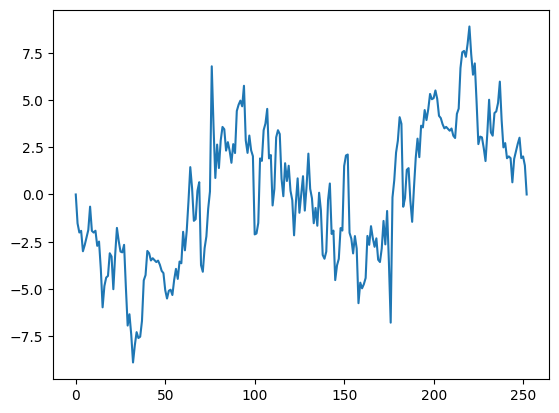

In [50]:
plt.plot(fourierInput)

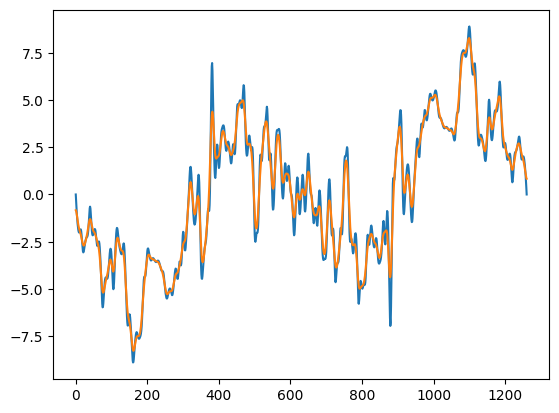

In [55]:
plt.plot(fourierInputSpline)
plt.plot(fourierInputSmooth)

In [ ]:
f_t = (a0 +
           a1 * np.cos(t) +
           a2 * np.cos(2 * t) +
           b1 * np.sin(t) +
           b2 * np.sin(2 * t))

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load and preprocess data
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_X = test_X.reshape((10000, 28, 28, 1)).astype('float32') / 255
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

print(type(train_X))
print(type(train_y))
print((train_X.shape))

# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile and train
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.fit(train_X, train_y, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate
test_loss, test_acc = model.evaluate(test_X, test_y)
print(f'Test accuracy: {test_acc}')


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(60000, 28, 28, 1)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0820 - loss: 2.3005
Test accuracy: 0.0812000036239624


Transformed training data shape: (60000, 1000)
Transformed testing data shape: (10000, 1000)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 678,026 (2.59 MB)

 Trainable params: 678,026 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
422/422 - 4s - 10ms/step - accuracy: 0.7034 - loss: 1.0054 - val_accuracy: 0.8833 - val_loss: 0.3614
Epoch 2/20
422/422 - 2s - 6ms/step - accuracy: 0.8463 - loss: 0.4647 - val_accuracy: 0.8982 - val_loss: 0.3204
Epoch 3/20
422/422 - 3s - 6ms/step - accuracy: 0.8697 - loss: 0.3921 - val_accuracy: 0.9213 - val_loss: 0.2458
Epoch 4/20
422/422 - 3s - 6ms/step - accuracy: 0.8814 - loss: 0.3565 - val_accuracy: 0.9227 - val_loss: 0.2392
Epoch 5/20
422/422 - 2s - 6ms/step - accuracy: 0.8949 - loss: 0.3200 - val_accuracy: 0.9338 - val_loss: 0.2169
Epoch 6/20
422/422 - 2s - 6ms/step - accuracy: 0.9030 - loss: 0.2946 - val_accuracy: 0.9300 - val_loss: 0.2261
Epoch 7/20
422/422 - 3s - 6ms/step - accuracy: 0.9059 - loss: 0.2805 - val_accuracy: 0.9353 - val_loss: 0.2110
Epoch 8/20
422/422 - 2s - 6ms/step - accuracy: 0.9121 - loss: 0.2673 - val_accuracy: 0.9312 - val_loss: 0.2275
Epoch 9/20
422/422 - 2s - 6ms/step - accuracy: 0.9162 - loss: 0.2515 - val_accuracy: 0.9398 - val_loss: 0.2045


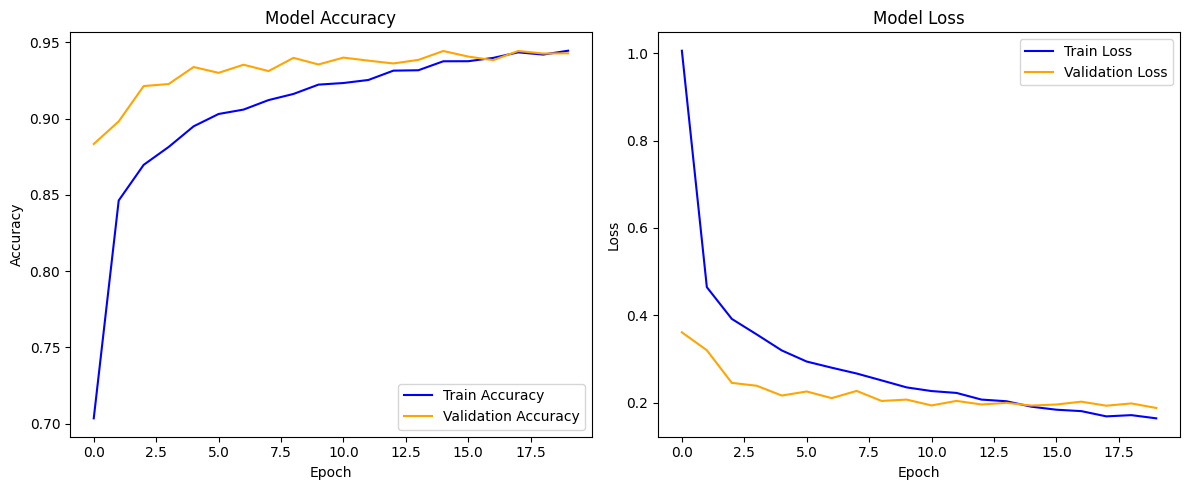

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

def getFourierConst(image, desired_length=1000):
    """
    Transforms a 2D image into a 1D Fourier-based feature vector of specified length.
    
    Parameters:
    - image: 2D numpy array representing the grayscale image.
    - desired_length: The length of the output feature vector (default is 1000).
    
    Returns:
    - features: 1D numpy array of length `desired_length`.
    """
    # Compute 2D FFT
    fft = np.fft.fft2(image)
    
    # Shift the zero-frequency component to the center
    fft_shift = np.fft.fftshift(fft)
    
    # Flatten the FFT result
    fft_flat = fft_shift.flatten()
    
    # Compute magnitude and phase
    magnitude = np.abs(fft_flat)
    phase = np.angle(fft_flat)
    
    # Combine magnitude and phase
    features = np.concatenate([magnitude, phase])
    
    # Adjust the feature vector to the desired length
    if len(features) > desired_length:
        features = features[:desired_length]
    elif len(features) < desired_length:
        features = np.pad(features, (0, desired_length - len(features)), 'constant')
    
    return features

# Load MNIST data
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Normalize the images to [0, 1]
train_X = train_X.astype('float32') / 255.0
test_X = test_X.astype('float32') / 255.0

# Convert labels to one-hot encoding
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

# Apply getFourierConst to each image in the training set
train_features = np.array([getFourierConst(image) for image in train_X])

# Apply getFourierConst to each image in the testing set
test_features = np.array([getFourierConst(image) for image in test_X])

print(f"Transformed training data shape: {train_features.shape}")
print(f"Transformed testing data shape: {test_features.shape}")

# Define the MLP model
model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(1000,)),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Display the model architecture
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_features, train_y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_features, test_y, verbose=0)
print(f'\nTest accuracy: {test_acc:.4f}')

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [23]:
train_features.shape

(60000, 1000)